In [1]:
# ! pip install transformers
# ! pip install datasets==2.21.0
# ! pip install
# ! pip install tqdm
# ! pip install
# ! pip install torchmetrics
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
import transformers as T
from torch.optim import AdamW
from tqdm import tqdm
from torchmetrics import SpearmanCorrCoef, Accuracy, F1Score

c:\Users\asdzx\anaconda3\envs\yolov7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 有些中文的標點符號在tokenizer編碼以後會變成[UNK]，所以將其換成英文標點
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [3]:
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        self.data = load_dataset(
            "sem_eval_2014_task_1", split=split, cache_dir="./cache/", trust_remote_code=True
        ).to_list()

    def __getitem__(self, index):
        d = self.data[index]
        # 把中文標點替換掉
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
        return d

    def __len__(self):
        return len(self.data)

In [4]:
# data_sample = SemevalDataset(split="train").data

# for i, sample in enumerate(data_sample):
#     if sample['entailment_judgment'] == 2:
#         print(f"Dataset example {i}: \n{sample}")

In [5]:
# Define the hyperparameters
lr =  1e-5
epochs = 10
train_batch_size = 8
validation_batch_size = 8

In [6]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.
tokenizer = T.BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

def collate_fn(batch):
    premises = [item['premise'] for item in batch]
    hypotheses = [item['hypothesis'] for item in batch]
    relatedness_scores = torch.tensor([item['relatedness_score'] for item in batch], dtype=torch.float32)
    entailment_judgments = torch.tensor([item['entailment_judgment'] for item in batch], dtype=torch.long)
    inputs = tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt")
    return {
        'input_ids': inputs['input_ids'],
        'token_type_ids': inputs['token_type_ids'],
        'attention_mask': inputs['attention_mask'],
        'relatedness_score': relatedness_scores,
        'entailment_judgment': entailment_judgments
        }
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.

# TODO1-2: Define your DataLoader
dataset_train = SemevalDataset(split="train")
dataset_val = SemevalDataset(split="validation")
dl_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
dl_validation = DataLoader(dataset_val, batch_size=validation_batch_size, shuffle=True, collate_fn=collate_fn)

In [7]:
print(next(iter(dl_train)))

{'input_ids': tensor([[  101,  1037,  2502,  4937,  2003,  3098,  1037,  6081, 13065,  2007,
          2049, 24392,  1998,  2003,  8660,  2503,   102,  1037,  4937,  2003,
          3098,  1037, 13065,  1998,  8218,  2503,   102,     0],
        [  101,  1996,  2158,  2003,  5128,  7975,  2046,  1996, 11661,   102,
          1037,  2158,  2003,  5128,  2070,  2833,  1999,  1037,  3482,   102,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2048,  4268,  2024,  6183,  2019,  1999, 10258, 27892, 21843,
          1999,  1037,  4770,   102,  2048,  4268,  2024,  6183,  2627,  1037,
         21843,  1999,  2019,  1999, 10258, 27892,  4770,   102],
        [  101,  2093,  3337,  2024,  3788,  2006,  5749,  2247,  1037,  2314,
           102,  1996,  2273,  1999,  2829,  9132,  2024,  2025,  3788,  2006,
          1996,  5749,  3875,  1037,  2314,   102,     0,     0],
        [  101,  1037,  3899,  2003,  6183,  1037,  6927,  3917,  2046,  1037,
          4

In [8]:
# TODO2: Construct your model
import torch.nn as nn
class MultiLabelModel(torch.nn.Module):
    def __init__(self, model_name = "google-bert/bert-base-uncased"):
        super(MultiLabelModel, self).__init__()
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.BertModel.from_pretrained(model_name)
        self.relatedness_score_layer = nn.Linear(self.bert.config.hidden_size, 1)
        self.entailment_judgment_layer = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # Get the outputs from BERT
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        cls_output = bert_output.pooler_output
        relatedness_score = self.relatedness_score_layer(cls_output)
        entailment_judgment = self.entailment_judgment_layer(cls_output)

        return {
            "relatedness_score": relatedness_score,
            "entailment_judgment": entailment_judgment
        }
        # Write your code here
        # Forward pass

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
model = MultiLabelModel("google-bert/bert-base-uncased").to(device)

Device: cuda:0


In [10]:
output = next(iter(dl_train))
print(output["relatedness_score"].size(), output["entailment_judgment"].size())

torch.Size([8]) torch.Size([8])


In [11]:
optimizer = AdamW(model.parameters(), lr=lr) # Write your code here

loss_fn_relatedness = nn.MSELoss()
loss_fn_entailment = nn.CrossEntropyLoss()

spc = SpearmanCorrCoef()
acc = Accuracy(task="multiclass", num_classes=3)
f1 = F1Score(task="multiclass", num_classes=3, average='macro')

c:\Users\asdzx\anaconda3\envs\yolov7\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [12]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    total_train_loss = 0
    for batch in pbar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        relatedness_scores = batch['relatedness_score'].to(device)
        entailment_judgments = batch['entailment_judgment'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        loss_relatedness = loss_fn_relatedness(outputs["relatedness_score"], relatedness_scores.view(-1, 1))
        loss_entailment = loss_fn_entailment(outputs["entailment_judgment"], entailment_judgments)

        loss = 0.5* loss_relatedness + 0.5*loss_entailment
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=total_train_loss / (pbar.n + 1))

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    total_val_loss = 0
    spc_score = 0
    acc_score = 0
    f1_score = 0
    with torch.no_grad():
        for batch in pbar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            relatedness_scores = batch['relatedness_score'].to(device)
            entailment_judgments = batch['entailment_judgment'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            loss_relatedness = loss_fn_relatedness(outputs["relatedness_score"], relatedness_scores.view(-1, 1))
            loss_entailment = loss_fn_entailment(outputs["entailment_judgment"], entailment_judgments)
            val_loss = loss_relatedness + loss_entailment
            total_val_loss += val_loss.item()

            spc_score += spc(outputs["relatedness_score"].cpu(), relatedness_scores.cpu().view(-1, 1))
            acc_score += acc(outputs["entailment_judgment"].cpu(), entailment_judgments.cpu())
            f1_score += f1(outputs["entailment_judgment"].cpu(), entailment_judgments.cpu())

        avg_val_loss = total_val_loss / len(dl_validation)
        avg_spc = spc_score / len(dl_validation)
        avg_acc = acc_score / len(dl_validation)
        avg_f1 = f1_score / len(dl_validation)

        print(f"Validation Loss: {avg_val_loss:.4f} | \nSpearman Corr: {avg_spc:.4f} | \nAccuracy: {avg_acc:.4f} | \nF1 Score: {avg_f1:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f'./saved_models/ep{ep}.pt')

Validation epoch [1/10]: 100%|██████████| 63/63 [00:01<00:00, 42.28it/s]


Validation Loss: 0.7724 | 
Spearman Corr: 0.7400 | 
Accuracy: 0.8056 | 
F1 Score: 0.7371


Validation epoch [2/10]: 100%|██████████| 63/63 [00:01<00:00, 42.22it/s]


Validation Loss: 0.7524 | 
Spearman Corr: 0.7520 | 
Accuracy: 0.8651 | 
F1 Score: 0.8252


Validation epoch [3/10]: 100%|██████████| 63/63 [00:01<00:00, 41.49it/s]


Validation Loss: 0.6316 | 
Spearman Corr: 0.7558 | 
Accuracy: 0.8631 | 
F1 Score: 0.8275


Validation epoch [4/10]: 100%|██████████| 63/63 [00:01<00:00, 39.94it/s]


Validation Loss: 0.6904 | 
Spearman Corr: 0.7637 | 
Accuracy: 0.8651 | 
F1 Score: 0.8139


Validation epoch [5/10]: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Validation Loss: 0.6744 | 
Spearman Corr: 0.7890 | 
Accuracy: 0.8492 | 
F1 Score: 0.8067


Validation epoch [6/10]: 100%|██████████| 63/63 [00:01<00:00, 39.96it/s]


Validation Loss: 0.7159 | 
Spearman Corr: 0.7561 | 
Accuracy: 0.8671 | 
F1 Score: 0.8326


Validation epoch [7/10]: 100%|██████████| 63/63 [00:01<00:00, 38.91it/s]


Validation Loss: 0.7151 | 
Spearman Corr: 0.7822 | 
Accuracy: 0.8651 | 
F1 Score: 0.8329


Validation epoch [8/10]: 100%|██████████| 63/63 [00:01<00:00, 33.15it/s]


Validation Loss: 0.6934 | 
Spearman Corr: 0.7828 | 
Accuracy: 0.8671 | 
F1 Score: 0.8115


Validation epoch [9/10]: 100%|██████████| 63/63 [00:01<00:00, 34.07it/s]


Validation Loss: 0.8046 | 
Spearman Corr: 0.7590 | 
Accuracy: 0.8671 | 
F1 Score: 0.8156


Validation epoch [10/10]: 100%|██████████| 63/63 [00:01<00:00, 33.18it/s]


Validation Loss: 0.7698 | 
Spearman Corr: 0.7743 | 
Accuracy: 0.8770 | 
F1 Score: 0.8403


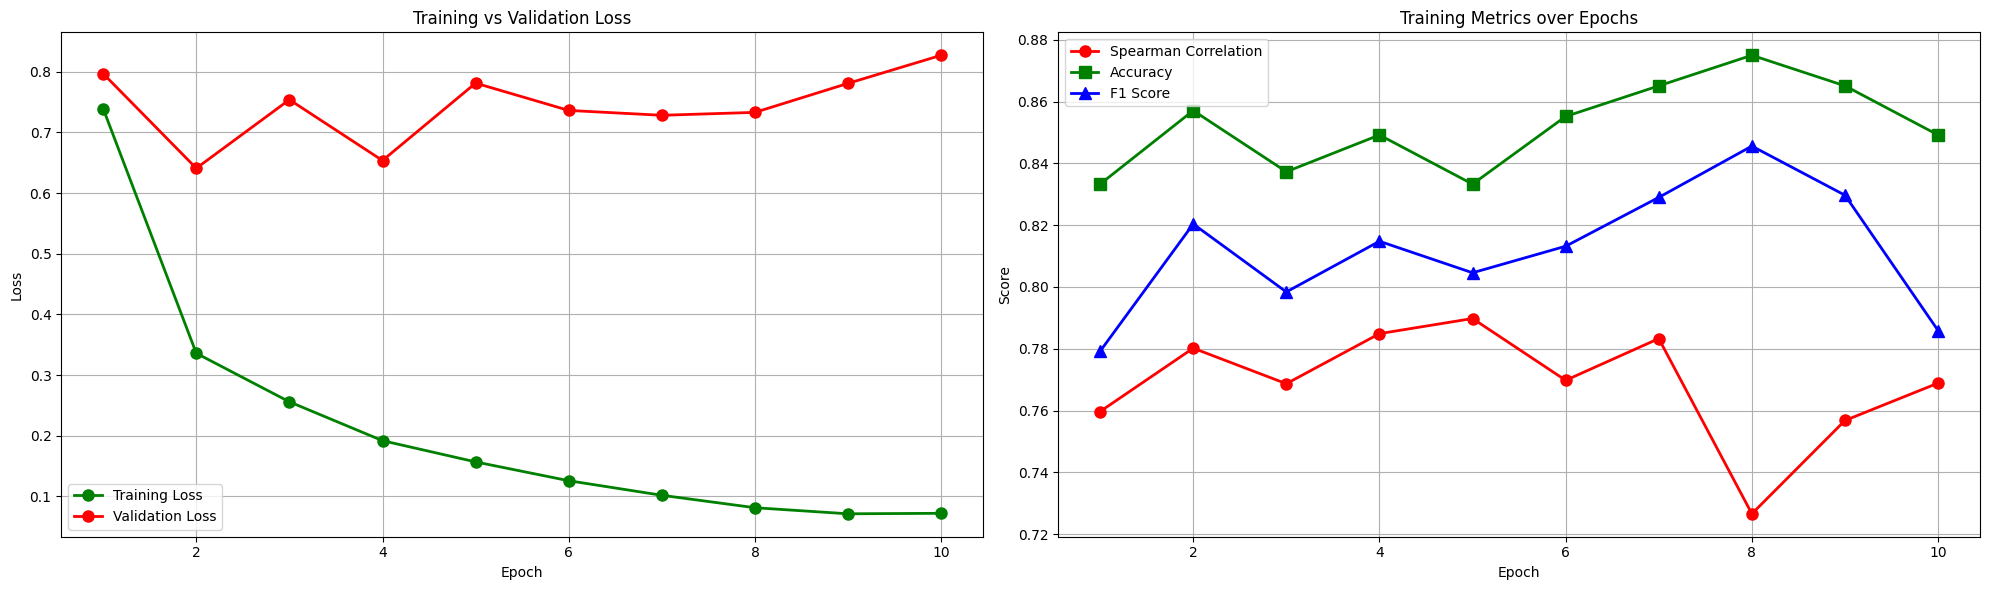

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
##(Ploting code is generate with ChatGPT)
# Training Loss data
train_loss = [0.739, 0.336, 0.256, 0.192, 0.157, 0.126, 0.102, 0.0815, 0.0715, 0.0723]

# Validation Loss data
val_loss = [0.7967, 0.6408, 0.7538, 0.6536, 0.7811, 0.7361, 0.7281, 0.7329, 0.7807, 0.8270]

# Other metrics data
spearman = [0.7597, 0.7802, 0.7687, 0.7849, 0.7898, 0.7698, 0.7833, 0.7266, 0.7568, 0.7689]
accuracy = [0.8333, 0.8571, 0.8373, 0.8492, 0.8333, 0.8552, 0.8651, 0.8750, 0.8651, 0.8492]
f1_score = [0.7792, 0.8204, 0.7984, 0.8148, 0.8046, 0.8132, 0.8290, 0.8456, 0.8297, 0.7859]

# Create figure with three subplots
plt.figure(figsize=(20, 6))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
epochs = range(1, 11)
plt.plot(epochs, train_loss, 'g-', marker='o', linewidth=2, markersize=8, label='Training Loss')
plt.plot(epochs, val_loss, 'r-', marker='o', linewidth=2, markersize=8, label='Validation Loss')
plt.title('Training vs Validation Loss', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Plot 3: Other Metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, spearman, 'r-', marker='o', label='Spearman Correlation', linewidth=2, markersize=8)
plt.plot(epochs, accuracy, 'g-', marker='s', label='Accuracy', linewidth=2, markersize=8)
plt.plot(epochs, f1_score, 'b-', marker='^', label='F1 Score', linewidth=2, markersize=8)
plt.title('Training Metrics over Epochs', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



```
# 此內容會顯示為程式碼
```

For test set predictions, you can write perform evaluation simlar to #TODO5.

In [13]:
dataset_test= SemevalDataset(split="test")
dl_test = DataLoader(dataset_test, batch_size=validation_batch_size, shuffle=True, collate_fn=collate_fn)

In [23]:
model.eval()
model.load_state_dict(torch.load('./saved_models/ep9.pt', map_location=device, weights_only=True), strict=True)
# 初始化累計變量
total_test_loss = 0
spc_score = 0
acc_score = 0
f1_score = 0
spearman_corr = SpearmanCorrCoef()
accuracy = Accuracy(task="multiclass", num_classes=3)
f1_score = F1Score(task="multiclass", num_classes=3, average='macro', zero_division=0)

with torch.no_grad():
    for batch in tqdm(dl_test, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        relatedness_scores = batch['relatedness_score'].to(device)
        entailment_judgments = batch['entailment_judgment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        loss_relatedness = loss_fn_relatedness(outputs["relatedness_score"], relatedness_scores.view(-1, 1))
        loss_entailment = loss_fn_entailment(outputs["entailment_judgment"], entailment_judgments)
        test_loss = loss_relatedness + loss_entailment
        total_test_loss += test_loss.item()
        # Update metrics
        spearman_corr.update(outputs["relatedness_score"].cpu(), relatedness_scores.cpu().view(-1, 1))
        accuracy.update(outputs["entailment_judgment"].cpu(), entailment_judgments.cpu())
        f1_score.update(outputs["entailment_judgment"].cpu(), entailment_judgments.cpu())

# Compute average loss and final metrics
average_test_loss = total_test_loss / len(dl_test)
spearman_corr_result = spearman_corr.compute()
accuracy_result = accuracy.compute()
f1_score_result = f1_score.compute()

# Print results
print(f"Test Loss: {average_test_loss:.4f} |")
print(f"Spearman Corr: {spearman_corr_result:.4f} |")
print(f"Accuracy: {accuracy_result:.4f} |")
print(f"F1 Score: {f1_score_result:.4f}")

Testing: 100%|██████████| 616/616 [00:12<00:00, 49.92it/s]

Test Loss: 0.7999 |
Spearman Corr: 0.8267 |
Accuracy: 0.8729 |
F1 Score: 0.8646


In [ ]:
class relatedness_score_Model(torch.nn.Module):
    def __init__(self, model_name = "google-bert/bert-base-uncased"):
        super(relatedness_score_Model, self).__init__()
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.BertModel.from_pretrained(model_name)
        self.relatedness_score_layer = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # Get the outputs from BERT
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        cls_output = bert_output.pooler_output
        relatedness_score = self.relatedness_score_layer(cls_output)

        return relatedness_score
    

In [ ]:
class entailment_judgment_Model(torch.nn.Module):
    def __init__(self, model_name = "google-bert/bert-base-uncased"):
        super(entailment_judgment_Model, self).__init__()
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.BertModel.from_pretrained(model_name)
        self.entailment_judgment_layer = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # Get the outputs from BERT
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        cls_output = bert_output.pooler_output
        entailment_judgment = self.entailment_judgment_layer(cls_output)

        return entailment_judgment

In [ ]:
relatedness_model = relatedness_score_Model(model_name = "google-bert/bert-base-uncased").to(device)
entailment_judgment_model = entailment_judgment_Model(model_name = "google-bert/bert-base-uncased").to(device)
optimizer_relatedness_model = AdamW(relatedness_model.parameters(), lr=lr)
optimizer_entailment_judgment_model= AdamW(entailment_judgment_model.parameters(), lr=lr)

In [ ]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    relatedness_model.train()
    total_train_loss = 0
    for batch in pbar:
        optimizer_relatedness_model.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        relatedness_scores = batch['relatedness_score'].to(device)
        outputs = relatedness_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        loss_relatedness = loss_fn_relatedness(outputs, relatedness_scores.view(-1, 1))
        total_train_loss += loss_relatedness.item()
        loss_relatedness.backward()
        optimizer_relatedness_model.step()
        pbar.set_postfix(loss_relatedness=total_train_loss / (pbar.n + 1))

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    relatedness_model.eval()
    total_val_loss = 0
    spc_score = 0
    with torch.no_grad():
        for batch in pbar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            relatedness_scores = batch['relatedness_score'].to(device)

            outputs = relatedness_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            loss_relatedness = loss_fn_relatedness(outputs, relatedness_scores.view(-1, 1))
            total_val_loss += loss_relatedness.item()

            spc_score += spc(outputs.cpu(), relatedness_scores.cpu().view(-1, 1))

        avg_val_loss = total_val_loss / len(dl_validation)
        avg_spc = spc_score / len(dl_validation)

        print(f"Validation Loss: {avg_val_loss:.4f} | \nSpearman Corr: {avg_spc:.4f} |\n")


Training epoch [1/10]:   0%|          | 0/563 [00:00<?, ?it/s]c:\Users\lab414\anaconda3\envs\pytorch\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Validation epoch [1/10]: 100%|██████████| 63/63 [00:00<00:00, 73.49it/s]


Validation Loss: 0.3371 | 
Spearman Corr: 0.7317 |



Validation epoch [2/10]: 100%|██████████| 63/63 [00:00<00:00, 97.95it/s] 


Validation Loss: 0.2886 | 
Spearman Corr: 0.7467 |



Validation epoch [3/10]: 100%|██████████| 63/63 [00:00<00:00, 95.58it/s]


Validation Loss: 0.2373 | 
Spearman Corr: 0.7257 |



Validation epoch [4/10]: 100%|██████████| 63/63 [00:02<00:00, 26.06it/s]


Validation Loss: 0.2549 | 
Spearman Corr: 0.7626 |



Validation epoch [5/10]: 100%|██████████| 63/63 [00:02<00:00, 31.04it/s]


Validation Loss: 0.2783 | 
Spearman Corr: 0.7608 |



Validation epoch [6/10]: 100%|██████████| 63/63 [00:00<00:00, 84.61it/s]


Validation Loss: 0.2299 | 
Spearman Corr: 0.7855 |



Validation epoch [7/10]: 100%|██████████| 63/63 [00:00<00:00, 77.55it/s]


Validation Loss: 0.2953 | 
Spearman Corr: 0.7777 |



Validation epoch [8/10]: 100%|██████████| 63/63 [00:00<00:00, 78.69it/s]


Validation Loss: 0.2706 | 
Spearman Corr: 0.7999 |



Validation epoch [9/10]: 100%|██████████| 63/63 [00:00<00:00, 79.52it/s]


Validation Loss: 0.2785 | 
Spearman Corr: 0.7783 |



Validation epoch [10/10]: 100%|██████████| 63/63 [00:03<00:00, 20.19it/s]

Validation Loss: 0.2641 | 
Spearman Corr: 0.7760 |



In [ ]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    entailment_judgment_model.train()
    total_train_loss = 0
    for batch in pbar:
        optimizer_entailment_judgment_model.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        entailment_judgments = batch['entailment_judgment'].to(device)
        outputs = entailment_judgment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        loss_entailment = loss_fn_entailment(outputs, entailment_judgments)

        total_train_loss += loss_entailment.item()
        loss_entailment.backward()
        optimizer_entailment_judgment_model.step()
        pbar.set_postfix(loss_entailment=total_train_loss / (pbar.n + 1))

    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    entailment_judgment_model.eval()
    total_val_loss = 0
    spc_score = 0
    acc_score = 0
    f1_score = 0
    with torch.no_grad():
        for batch in pbar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            entailment_judgments = batch['entailment_judgment'].to(device)

            outputs = entailment_judgment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            loss_entailment = loss_fn_entailment(outputs, entailment_judgments)
            val_loss = loss_entailment
            total_val_loss += val_loss.item()

            acc_score += acc(outputs.cpu(), entailment_judgments.cpu())
            f1_score += f1(outputs.cpu(), entailment_judgments.cpu())

        avg_val_loss = total_val_loss / len(dl_validation)
        avg_acc = acc_score / len(dl_validation)
        avg_f1 = f1_score / len(dl_validation)

        print(f"Validation Loss: {avg_val_loss:.4f} | \n\nAccuracy: {avg_acc:.4f} | \nF1 Score: {avg_f1:.4f}")

Validation epoch [1/10]: 100%|██████████| 63/63 [00:02<00:00, 28.46it/s]


Validation Loss: 0.3866 | 

Accuracy: 0.8492 | 
F1 Score: 0.8143


Validation epoch [2/10]: 100%|██████████| 63/63 [00:00<00:00, 108.11it/s]


Validation Loss: 0.3465 | 

Accuracy: 0.8671 | 
F1 Score: 0.8238


Validation epoch [3/10]: 100%|██████████| 63/63 [00:00<00:00, 108.43it/s]


Validation Loss: 0.3648 | 

Accuracy: 0.8651 | 
F1 Score: 0.8439


Validation epoch [4/10]: 100%|██████████| 63/63 [00:00<00:00, 109.45it/s]


Validation Loss: 0.3961 | 

Accuracy: 0.8671 | 
F1 Score: 0.8183


Validation epoch [5/10]: 100%|██████████| 63/63 [00:00<00:00, 103.21it/s]


Validation Loss: 0.4893 | 

Accuracy: 0.8750 | 
F1 Score: 0.8176


Validation epoch [6/10]: 100%|██████████| 63/63 [00:00<00:00, 104.72it/s]


Validation Loss: 0.5191 | 

Accuracy: 0.8671 | 
F1 Score: 0.8185


Validation epoch [7/10]: 100%|██████████| 63/63 [00:03<00:00, 19.54it/s]


Validation Loss: 0.5020 | 

Accuracy: 0.8710 | 
F1 Score: 0.8479


Validation epoch [8/10]: 100%|██████████| 63/63 [00:00<00:00, 107.88it/s]


Validation Loss: 0.5299 | 

Accuracy: 0.8750 | 
F1 Score: 0.8489


Validation epoch [9/10]: 100%|██████████| 63/63 [00:00<00:00, 108.51it/s]


Validation Loss: 0.5483 | 

Accuracy: 0.8651 | 
F1 Score: 0.8325


Validation epoch [10/10]: 100%|██████████| 63/63 [00:00<00:00, 104.84it/s]

Validation Loss: 0.6675 | 

Accuracy: 0.8690 | 
F1 Score: 0.8227


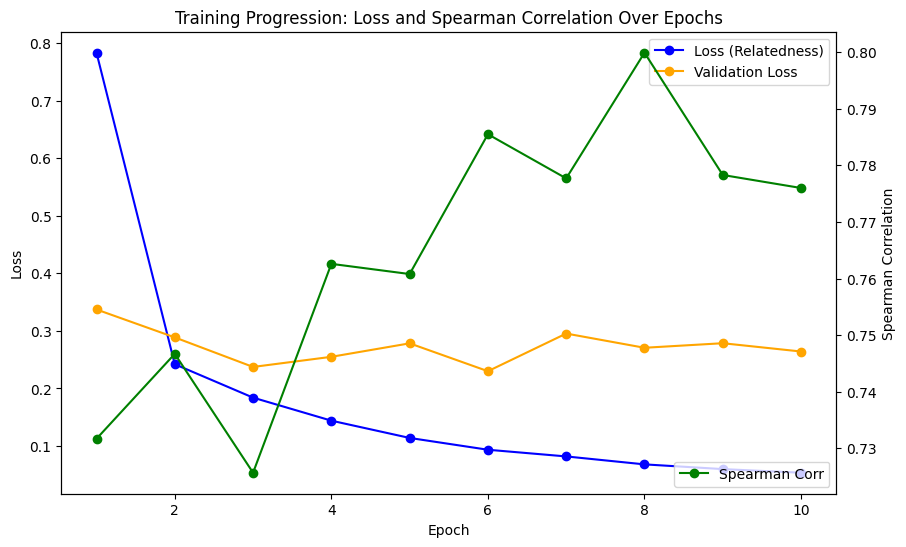

In [ ]:
import matplotlib.pyplot as plt
##(Ploting code is generate with ChatGPT)
# Training and validation data
epochs = list(range(1, 11))
loss_relatedness = [0.783, 0.242, 0.184, 0.144, 0.114, 0.0935, 0.0819, 0.0681, 0.0599, 0.0536]
validation_loss = [0.3371, 0.2886, 0.2373, 0.2549, 0.2783, 0.2299, 0.2953, 0.2706, 0.2785, 0.2641]
spearman_corr = [0.7317, 0.7467, 0.7257, 0.7626, 0.7608, 0.7855, 0.7777, 0.7999, 0.7783, 0.7760]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Loss
ax1.plot(epochs, loss_relatedness, label='Loss (Relatedness)', color='blue', marker='o')
ax1.plot(epochs, validation_loss, label='Validation Loss', color='orange', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Plot Spearman Correlation on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, spearman_corr, label='Spearman Corr', color='green', marker='o')
ax2.set_ylabel('Spearman Correlation')
ax2.legend(loc='lower right')

plt.title('Training Progression: Loss and Spearman Correlation Over Epochs')
plt.show()

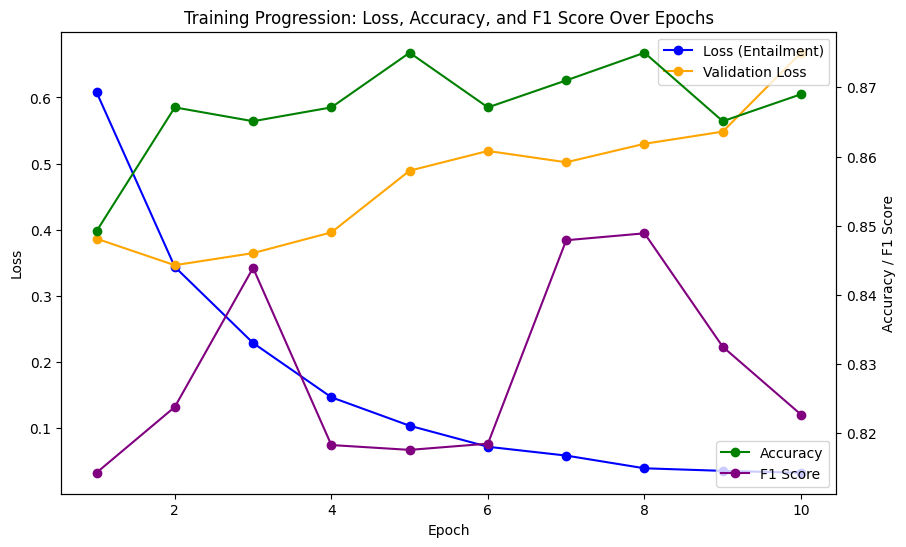

In [ ]:
##(Ploting code is generate with ChatGPT)
loss_entailment = [0.608, 0.344, 0.229, 0.147, 0.104, 0.0722, 0.0589, 0.0397, 0.0358, 0.033]
validation_loss = [0.3866, 0.3465, 0.3648, 0.3961, 0.4893, 0.5191, 0.5020, 0.5299, 0.5483, 0.6675]
accuracy = [0.8492, 0.8671, 0.8651, 0.8671, 0.8750, 0.8671, 0.8710, 0.8750, 0.8651, 0.8690]
f1_score = [0.8143, 0.8238, 0.8439, 0.8183, 0.8176, 0.8185, 0.8479, 0.8489, 0.8325, 0.8227]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(epochs, loss_entailment, label='Loss (Entailment)', color='blue', marker='o')
ax1.plot(epochs, validation_loss, label='Validation Loss', color='orange', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(epochs, accuracy, label='Accuracy', color='green', marker='o')
ax2.plot(epochs, f1_score, label='F1 Score', color='purple', marker='o')
ax2.set_ylabel('Accuracy / F1 Score')
ax2.legend(loc='lower right')

plt.title('Training Progression: Loss, Accuracy, and F1 Score Over Epochs')
plt.show()